In [1]:
import os
import pickle
from inspect import signature

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve

import missingno as msno


from IPython.display import display, HTML

import warnings
# warnings.filterwarnings('ignore')

# load custom functions
os.chdir('C:/Users/kyleg/Entity-Matching-in-Online-Retail')
# os.chdir('H:/kgilde/Entity-Matching-in-Online-Retail')
exec(open("utility_functions.py").read())

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Entity Matching for Online Marketplaces



## What is Entity Matching (EM)?

## Why is EM needed for online marketplaces?

## Exploratory Data Analysis

### Dataset Origin

### Offer Features

In [2]:
# Load Data
# DATA_DIRECTORY = '//files/share/goods/OI Team'
ORIGINAL_DIRECTORY = os.getcwd()
DATA_DIRECTORY = 'D:/Documents/Large-Scale Product Matching/'
os.chdir(DATA_DIRECTORY)

# load some feature data
train_test_feature_pairs = pd.read_csv('train_test_feature_pairs.csv')
train_test_offer_features = pd.read_csv('train_test_offer_features.csv')
train_test_normalized_features = pd.read_csv('train_test_normalized_features.csv')
attribute_comp_features_9 = pd.read_csv('attribute_comparison_features-9.csv')

# load some metrics
feature_avgs = pd.read_csv('Output Metrics - Feature Avgs.csv')
model_avgs = pd.read_csv('Output Metrics - Model Avgs.csv')
var_imp_coef = pd.read_csv('logreg-variable-coefficients-importance.csv').set_index('Feature')

C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [43]:
# load some models
os.chdir(DATA_DIRECTORY + '/attribute_comparison_features-9')

acf9_models = pickle.load(open('sklearn_models.pkl', 'rb'))
acf9_class_proba = pickle.load(open('sklearn_class_probabilities.pkl', 'rb'))[2]
acf9_rf_pred = pickle.load(open('sklearn_test_predictions.pkl', 'rb'))[2]


C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator GaussianNB from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator SVC from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator SVC from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid re

C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using ve

In [47]:
# PLOT_DIRECTORY = '//files/share/goods/OI Team/plots'
PLOT_DIRECTORY = 'plots'
SHORT_TEXT_FEATURES = ['gtin', 'mpn', 'sku', 'identifier', 'brand', 'manufacturer']
PRODUCT_IDENTIFIERS = ['gtin', 'mpn', 'sku', 'identifier']
BRAND_MANUFACTURER =  ['brand', 'manufacturer']
MEDIUM_LONG_TEXT_FEATURES = ['name', 'description']
OTHER_FEATURES = ['price']
ALL_FEATURES = SHORT_TEXT_FEATURES + MEDIUM_LONG_TEXT_FEATURES + OTHER_FEATURES
  
test_ids = train_test_feature_pairs[(train_test_feature_pairs.label == 1) &
                                    (train_test_feature_pairs.dataset == 'test')]\
                [['offer_id_1', 'offer_id_2']]\
                .stack()\
                .unique()
    
train_test_offer_features_only = train_test_offer_features[ALL_FEATURES]
test_offer_features_only = train_test_offer_features.loc[train_test_offer_features.offer_id.isin(test_ids), ALL_FEATURES]

os.chdir(ORIGINAL_DIRECTORY)
os.chdir(PLOT_DIRECTORY)

### Top Domains

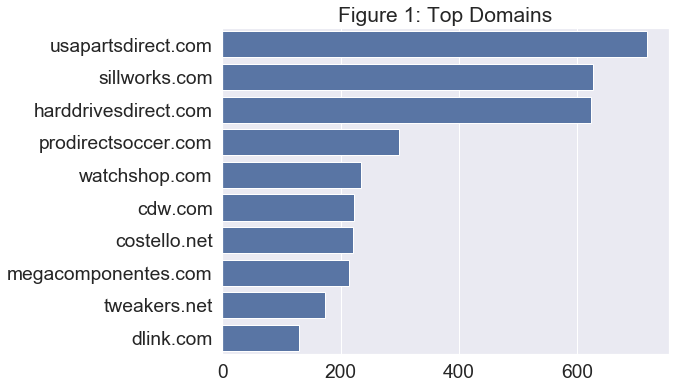

In [5]:
domains = train_test_offer_features.domain.str.replace('www\.|de\.', '')\
    .value_counts().head(10)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.75)

sns.barplot(x=domains.values, y=domains.index, 
            color="b")\
            .set_title('Figure 1: Top Domains')

plt.savefig('fig-01-top-domains.png', bbox_inches = "tight")


### Sparsity

In [6]:
null_percentages = calculate_percent_nulls(train_test_offer_features_only, print_series=False, return_series=True)
nulls_by_index = train_test_offer_features[null_percentages.index].isnull().T

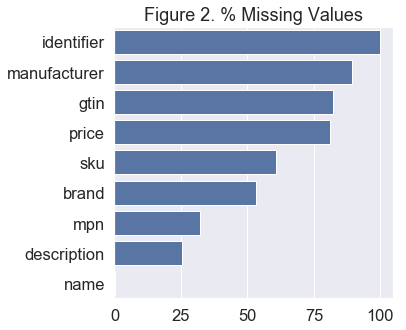

In [7]:
plt.figure(figsize=(5, 5))
sns.set(font_scale=1.5)

sns.barplot(x=null_percentages.values, 
            y=null_percentages.index, 
            color="b")\
            .set_title('Figure 2. % Missing Values')

plt.savefig("fig-02-feature-sparsity.png", bbox_inches = "tight")

In [8]:
msno.heatmap

<function missingno.missingno.heatmap(df, inline=False, filter=None, n=0, p=0, sort=None, figsize=(20, 12), fontsize=16, labels=True, cmap='RdBu')>

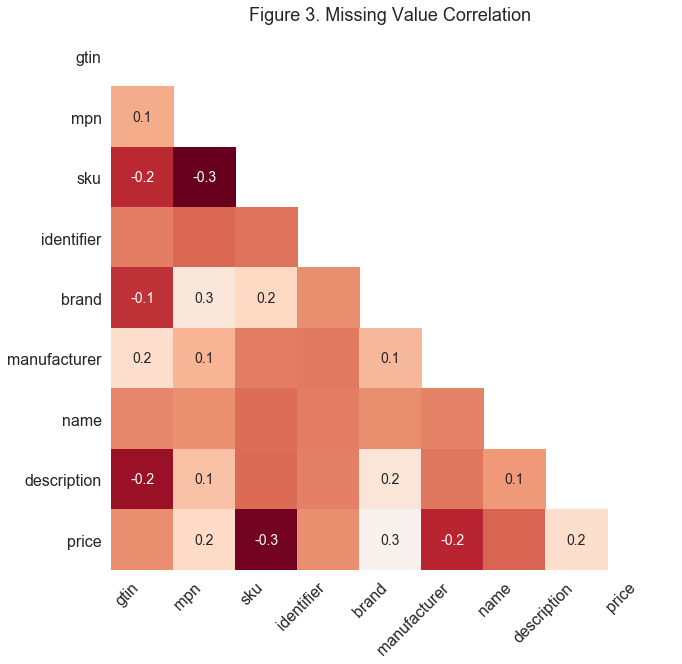

In [9]:
msno.heatmap(train_test_offer_features_only, figsize=(10, 10)).set_title("Figure 3. Missing Value Correlation")

plt.savefig("fig-03-missing-value-correlation.png", bbox_inches = "tight")

## Features

### Short Text Character Lengths

In [10]:
# count chararters for short-text features
# identifiers_features = train_test_normalized_features[PRODUCT_IDENTIFIERS]
# char_counts_identifiers_features = identifiers_features.apply(lambda s: s.str.len(), axis=1)
short_text_features = train_test_normalized_features[SHORT_TEXT_FEATURES]
char_counts_df = short_text_features.apply(lambda s: s.str.len(), axis=1)

In [11]:
char_counts_df.median()

gtin            12.0
mpn              9.0
sku              9.0
identifier       9.0
brand           13.0
manufacturer     7.0
dtype: float64

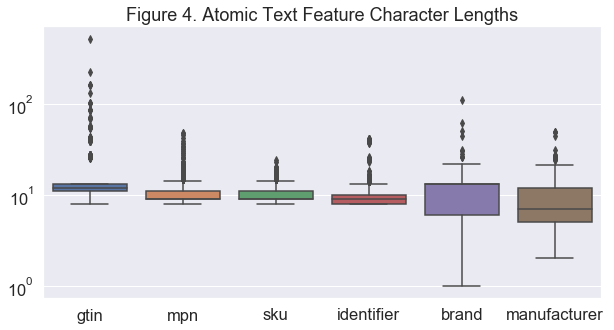

In [12]:
plt.figure(figsize=(10, 5))
sns.set(font_scale=1.5)

ax = sns.boxplot(data = char_counts_df)
ax.set_title('Figure 4. Atomic Text Feature Character Lengths')

ax.set(yscale='log')

# plt.figure(figsize=(10, 5))
# sns.set(font_scale=1.5)

# ax = sns.boxplot(data = char_counts_identifiers_features)
# ax.set_title('Figure 4. Product Identifier Character Lengths')
# ax.xaxis.tick_top()
# ax.set(yscale='log')

plt.savefig("fig-04-character-lengths.png", bbox_inches = "tight")

### Top Brands & Manufacturers

In [13]:
top_values =\
    train_test_normalized_features[['brand', 'manufacturer']]\
        .melt()\
        .dropna().groupby(['variable', 'value'])['value'].agg('count')\
        .to_frame()\
        .rename(index=str, columns={'value': 'value_counts'})\
        .reset_index()\
        .groupby(['variable'])\
        .apply(lambda x: x.nlargest(10, 'value_counts'))\
        .reset_index(drop=True)

top_values['value'] = top_values.value.str.slice(stop=25)

C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 3600x1800 with 0 Axes>

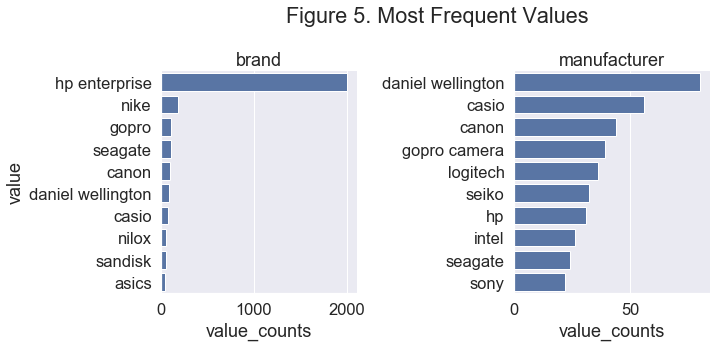

In [14]:
plt.figure(figsize=(50, 25))
g = sns.FacetGrid(top_values, col="variable", col_wrap=5, sharey=False, sharex=False)
g.fig.set_figwidth(25)
g.fig.set_figheight(5)
g.map(sns.barplot, 'value_counts', 'value')
g.set_titles("{col_name}") 
plt.subplots_adjust(top=.8)
g.fig.suptitle('Figure 5. Most Frequent Values', x=.25)
                    
plt.savefig("fig-05-brand-manufacturer-top-values.png", bbox_inches = "tight")
# https://stackoverflow.com/a/48208266/4463701

In [15]:
overlap = train_test_normalized_features[['brand', 'manufacturer']].dropna().apply(lambda x: x[0] == x[1], 1).value_counts()
overlap / overlap.sum()

True     0.779359
False    0.220641
dtype: float64

In [16]:
# count words
medium_long_features = train_test_normalized_features[MEDIUM_LONG_TEXT_FEATURES]
word_counts_df = medium_long_features.apply(count_words, axis=1)

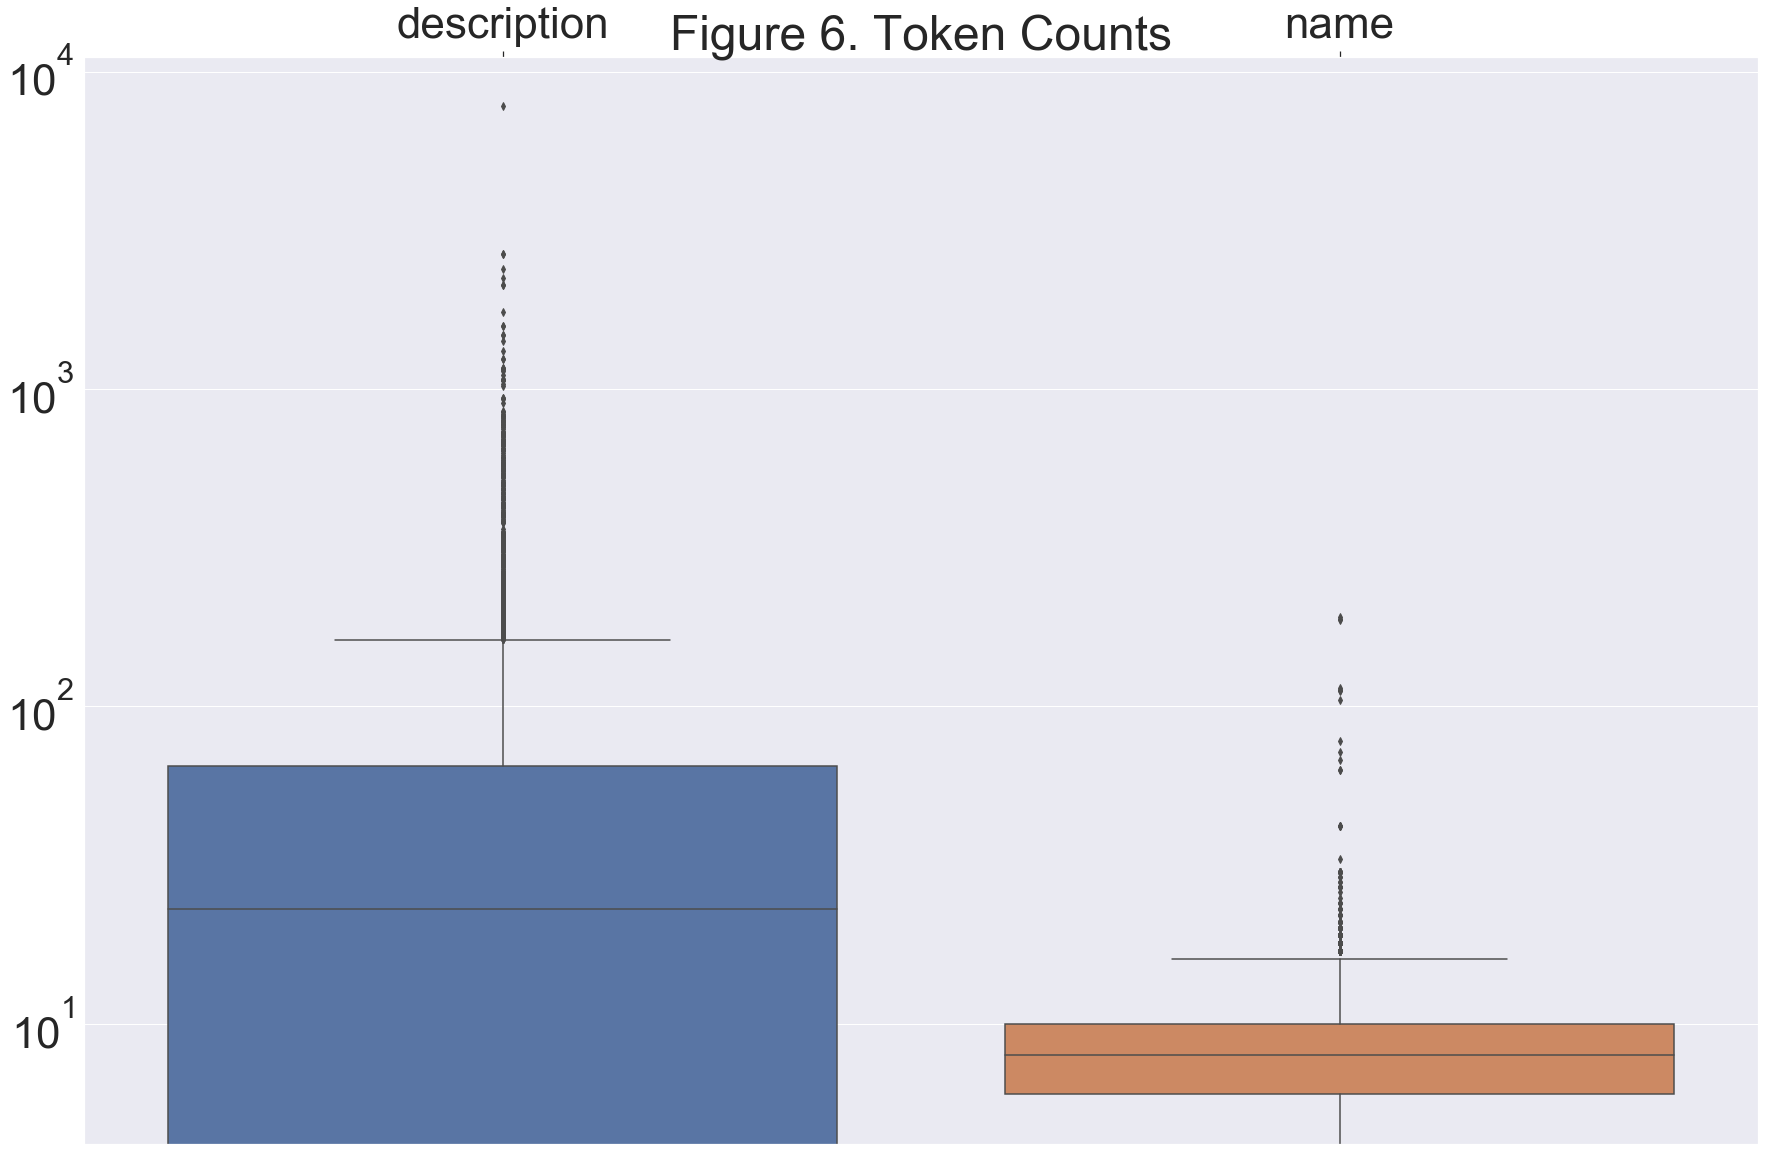

In [17]:
plt.figure(figsize=(30, 20))
sns.set(font_scale=4)

ax = sns.boxplot(data = word_counts_df)
ax.set_title('Figure 6. Token Counts')
ax.xaxis.tick_top()
ax.set(yscale='log')

plt.savefig("fig-06-name-descrition-word-counts.png", bbox_inches = "tight")

In [18]:
word_counts_df.median()

description    23.0
name            8.0
dtype: float64

### Training & Testing Data

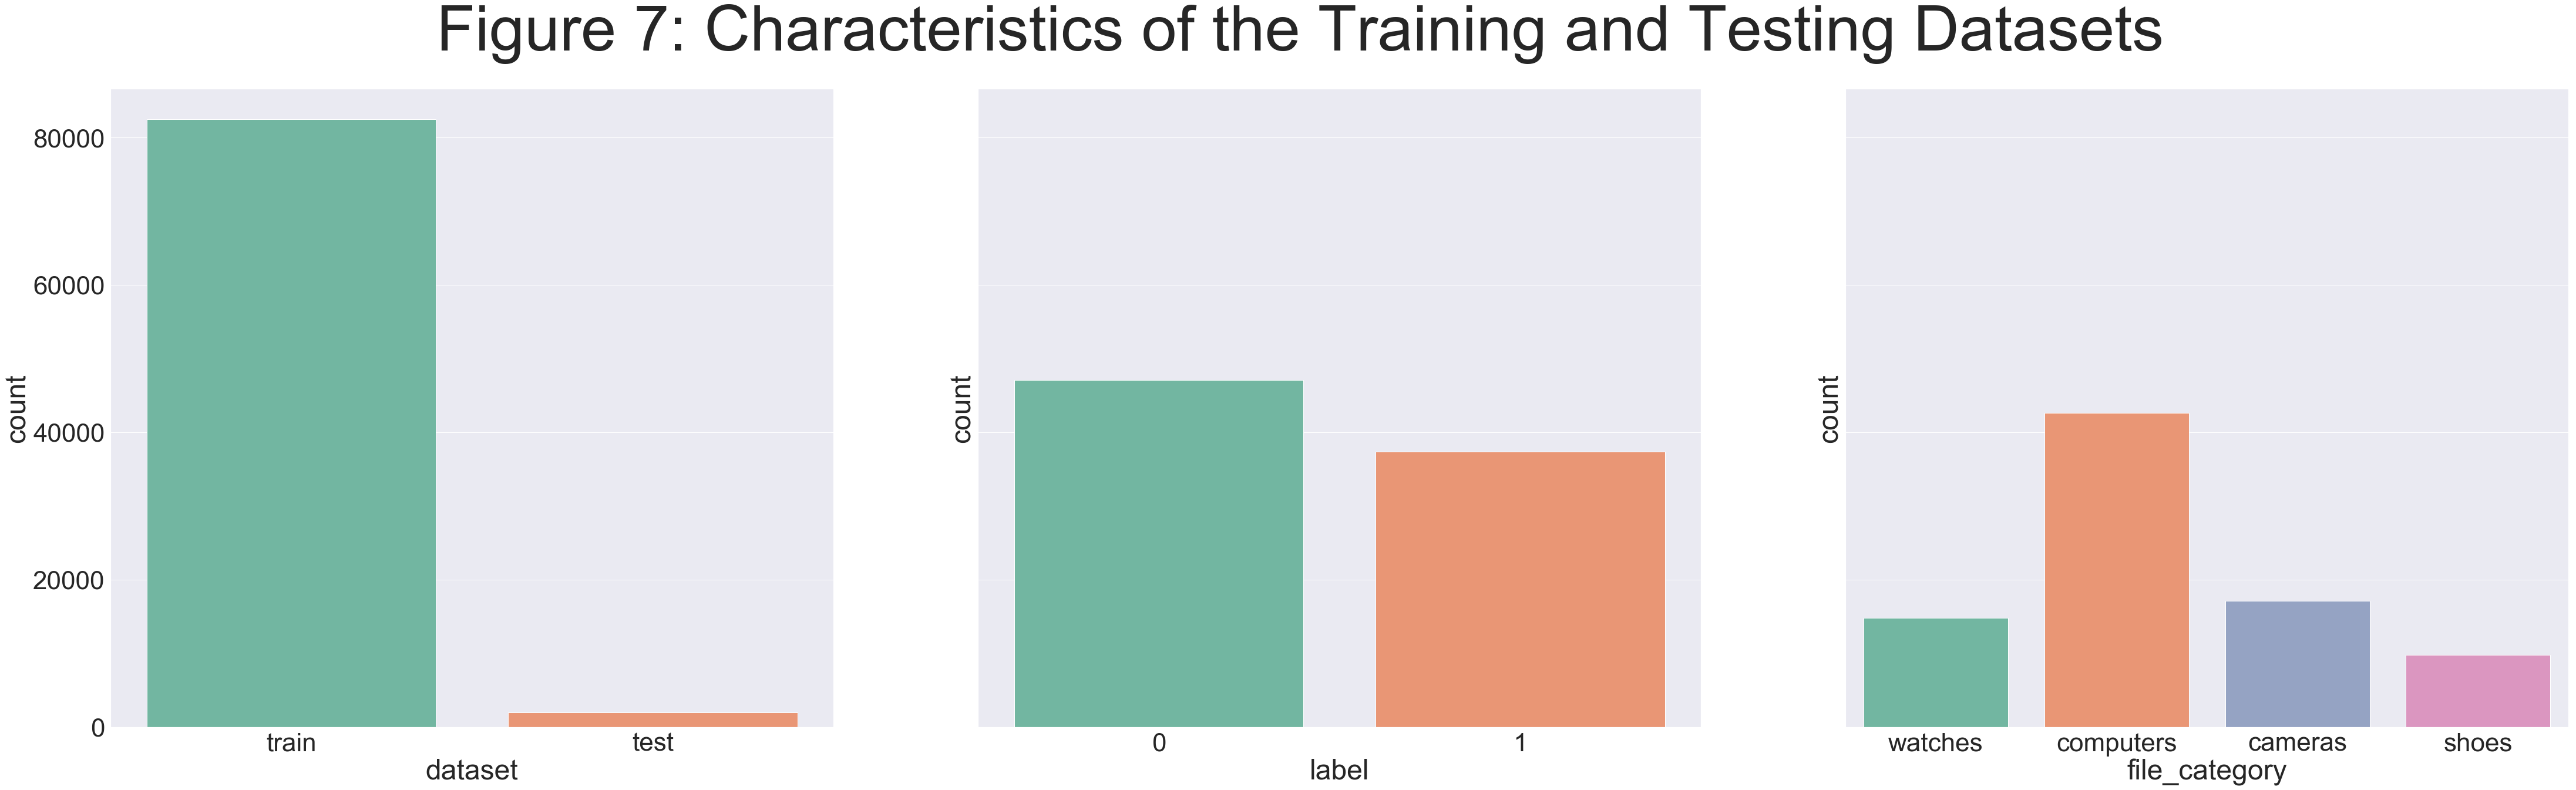

In [19]:
test_train_characteristics = train_test_feature_pairs[['label', 'dataset', 'file_category']]


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(75, 20), sharey=True) 

sns.set(font_scale=5.5)
plt.rcParams.update({'font.size': 90})
st = fig.suptitle("Figure 7: Characteristics of the Training and Testing Datasets")

sns.countplot(x='dataset', data=test_train_characteristics, palette=sns.color_palette("Set2"), ax=axes[0])

sns.countplot(x='label', data=test_train_characteristics, palette=sns.color_palette("Set2"), ax=axes[1])

sns.countplot(x='file_category', data=test_train_characteristics, palette=sns.color_palette("Set2"), ax=axes[2])

plt.savefig('fig-07-test-train-characteristics.png', bbox_inches = "tight")

### Testing Data

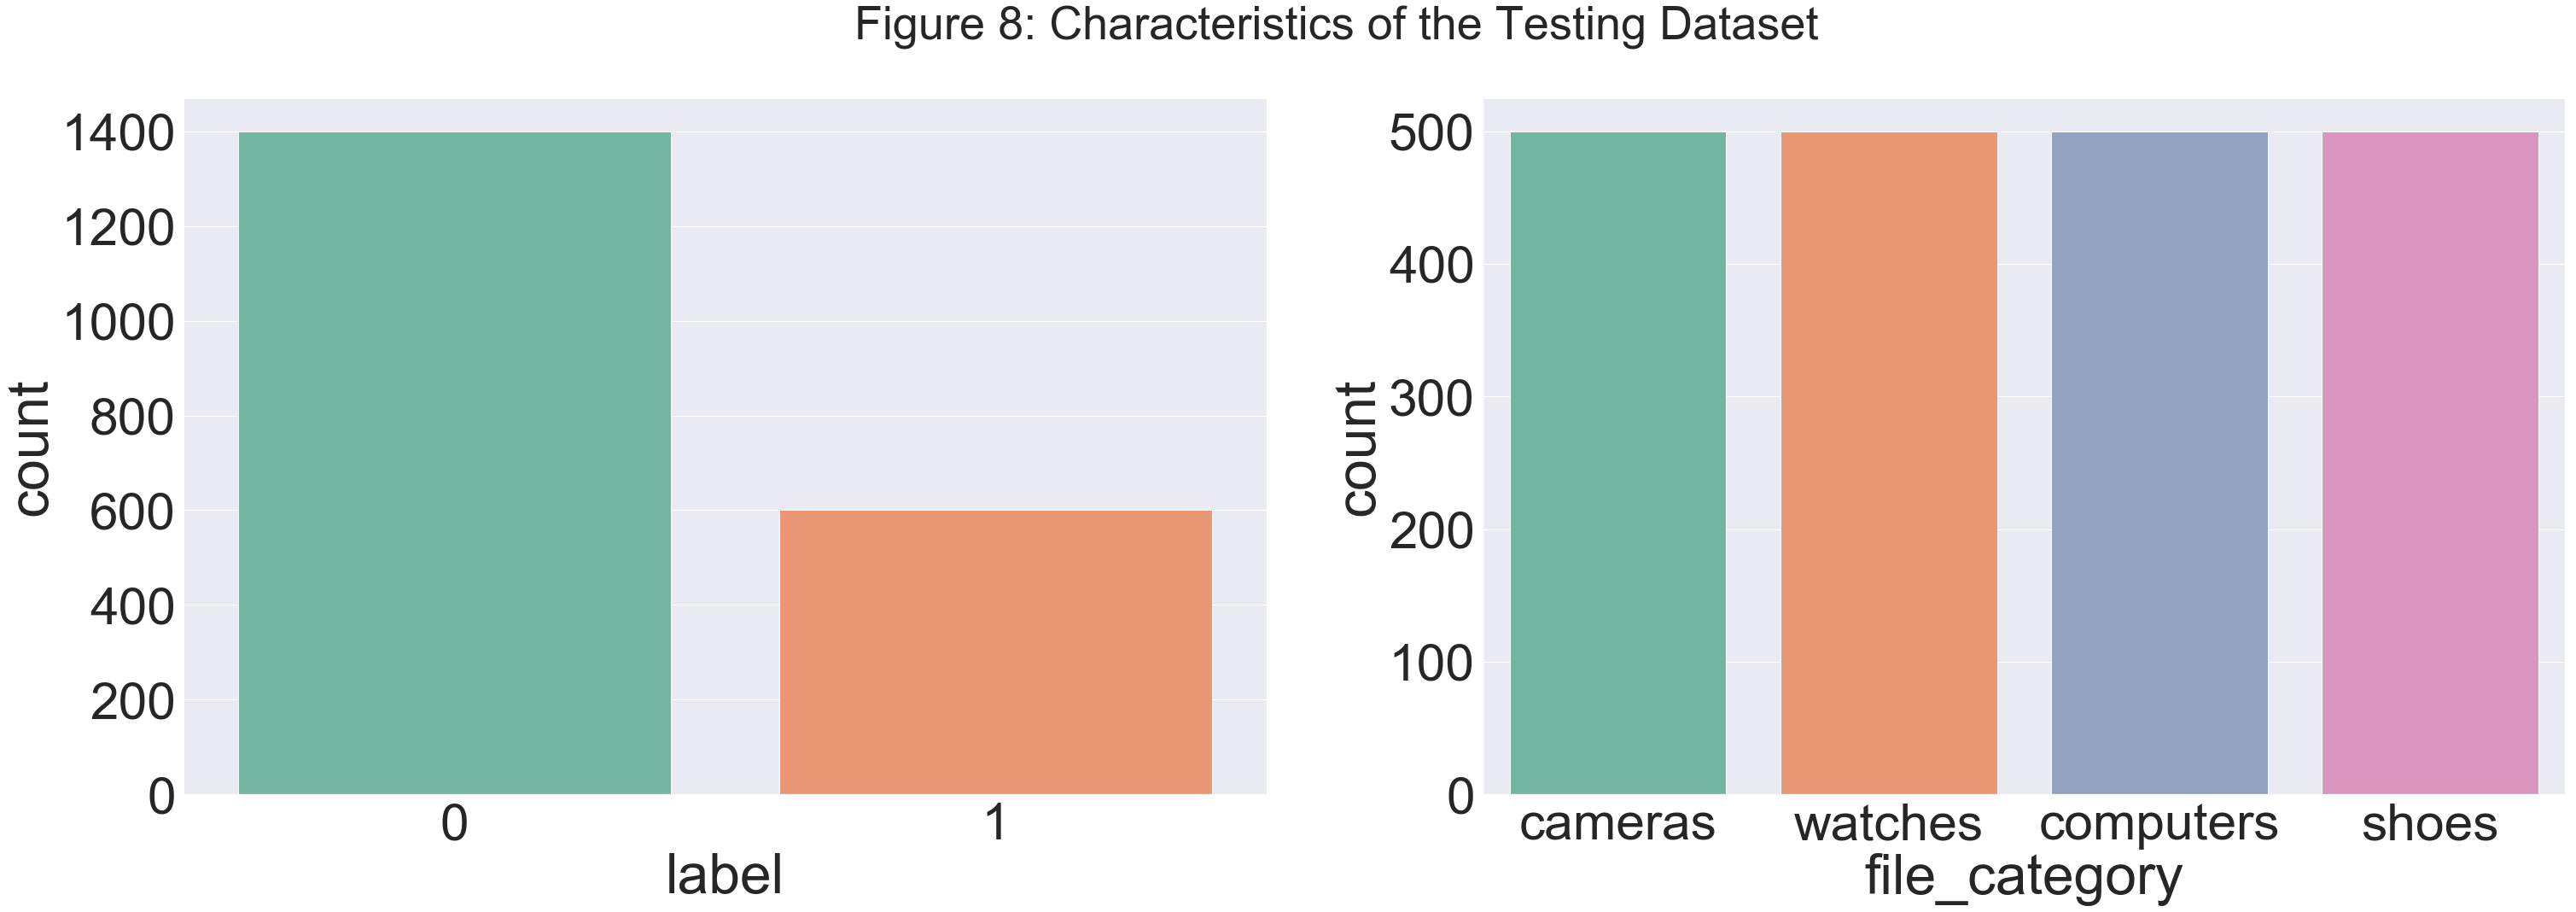

In [20]:
test_characteristics = test_train_characteristics[test_train_characteristics.dataset == 'test']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50, 15)) #

sns.set(font_scale=4)
plt.rcParams.update({'font.size': 45})
st = fig.suptitle("Figure 8: Characteristics of the Testing Dataset")

sns.countplot(x='label', data=test_characteristics, palette=sns.color_palette("Set2"), ax=axes[0])

sns.countplot(x='file_category', data=test_characteristics, palette=sns.color_palette("Set2"), ax=axes[1])

plt.savefig('fig-08-test-set-characteristics.png')

In [21]:
test_matches = train_test_feature_pairs[(train_test_feature_pairs.label == 1) &
                                      (train_test_feature_pairs.dataset == 'test')][['file_category', 
                                                                                   'name_1', 
                                                                                   'name_2']]\
.sample(4, random_state=1)

pd.set_option('display.max_colwidth', 0)
h = HTML(test_matches.to_html(index=False))
display(h)

my_file = open('table_1_matched_offer_pairs.html', 'w')
my_file.write(h.data)
my_file.close()

file_category,name_1,name_2
shoes,nike sportswear air force 1 07 white,sneakers buty nike air force 1 07 low white 315122 111
computers,323146 b21 bl20p g2 1p xeon 3 06ghz,323146 b21 bl20p xeon 3 06ghz
watches,daniel wellington dapper sheffield rose gold,daniel wellington men s dapper 38mm sheffield rose watch
cameras,canon eos rebel t5i,canon eos rebel t5i 18 135mm is stm digital slr camera kit black


### Feature Analysis

### Scatter and Density Plots

In [51]:
def hide_current_axis(*args, **kwds):
    """
    hides an axis
    """
    # source: https://stackoverflow.com/a/55834340/4463701
    plt.gca().set_visible(False)

attribute_comp_features_9_feat_label = attribute_comp_features_9[ALL_FEATURES + ['label']]

C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\kyleg\Anaconda3\envs\py36\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


<Figure size 864x864 with 0 Axes>

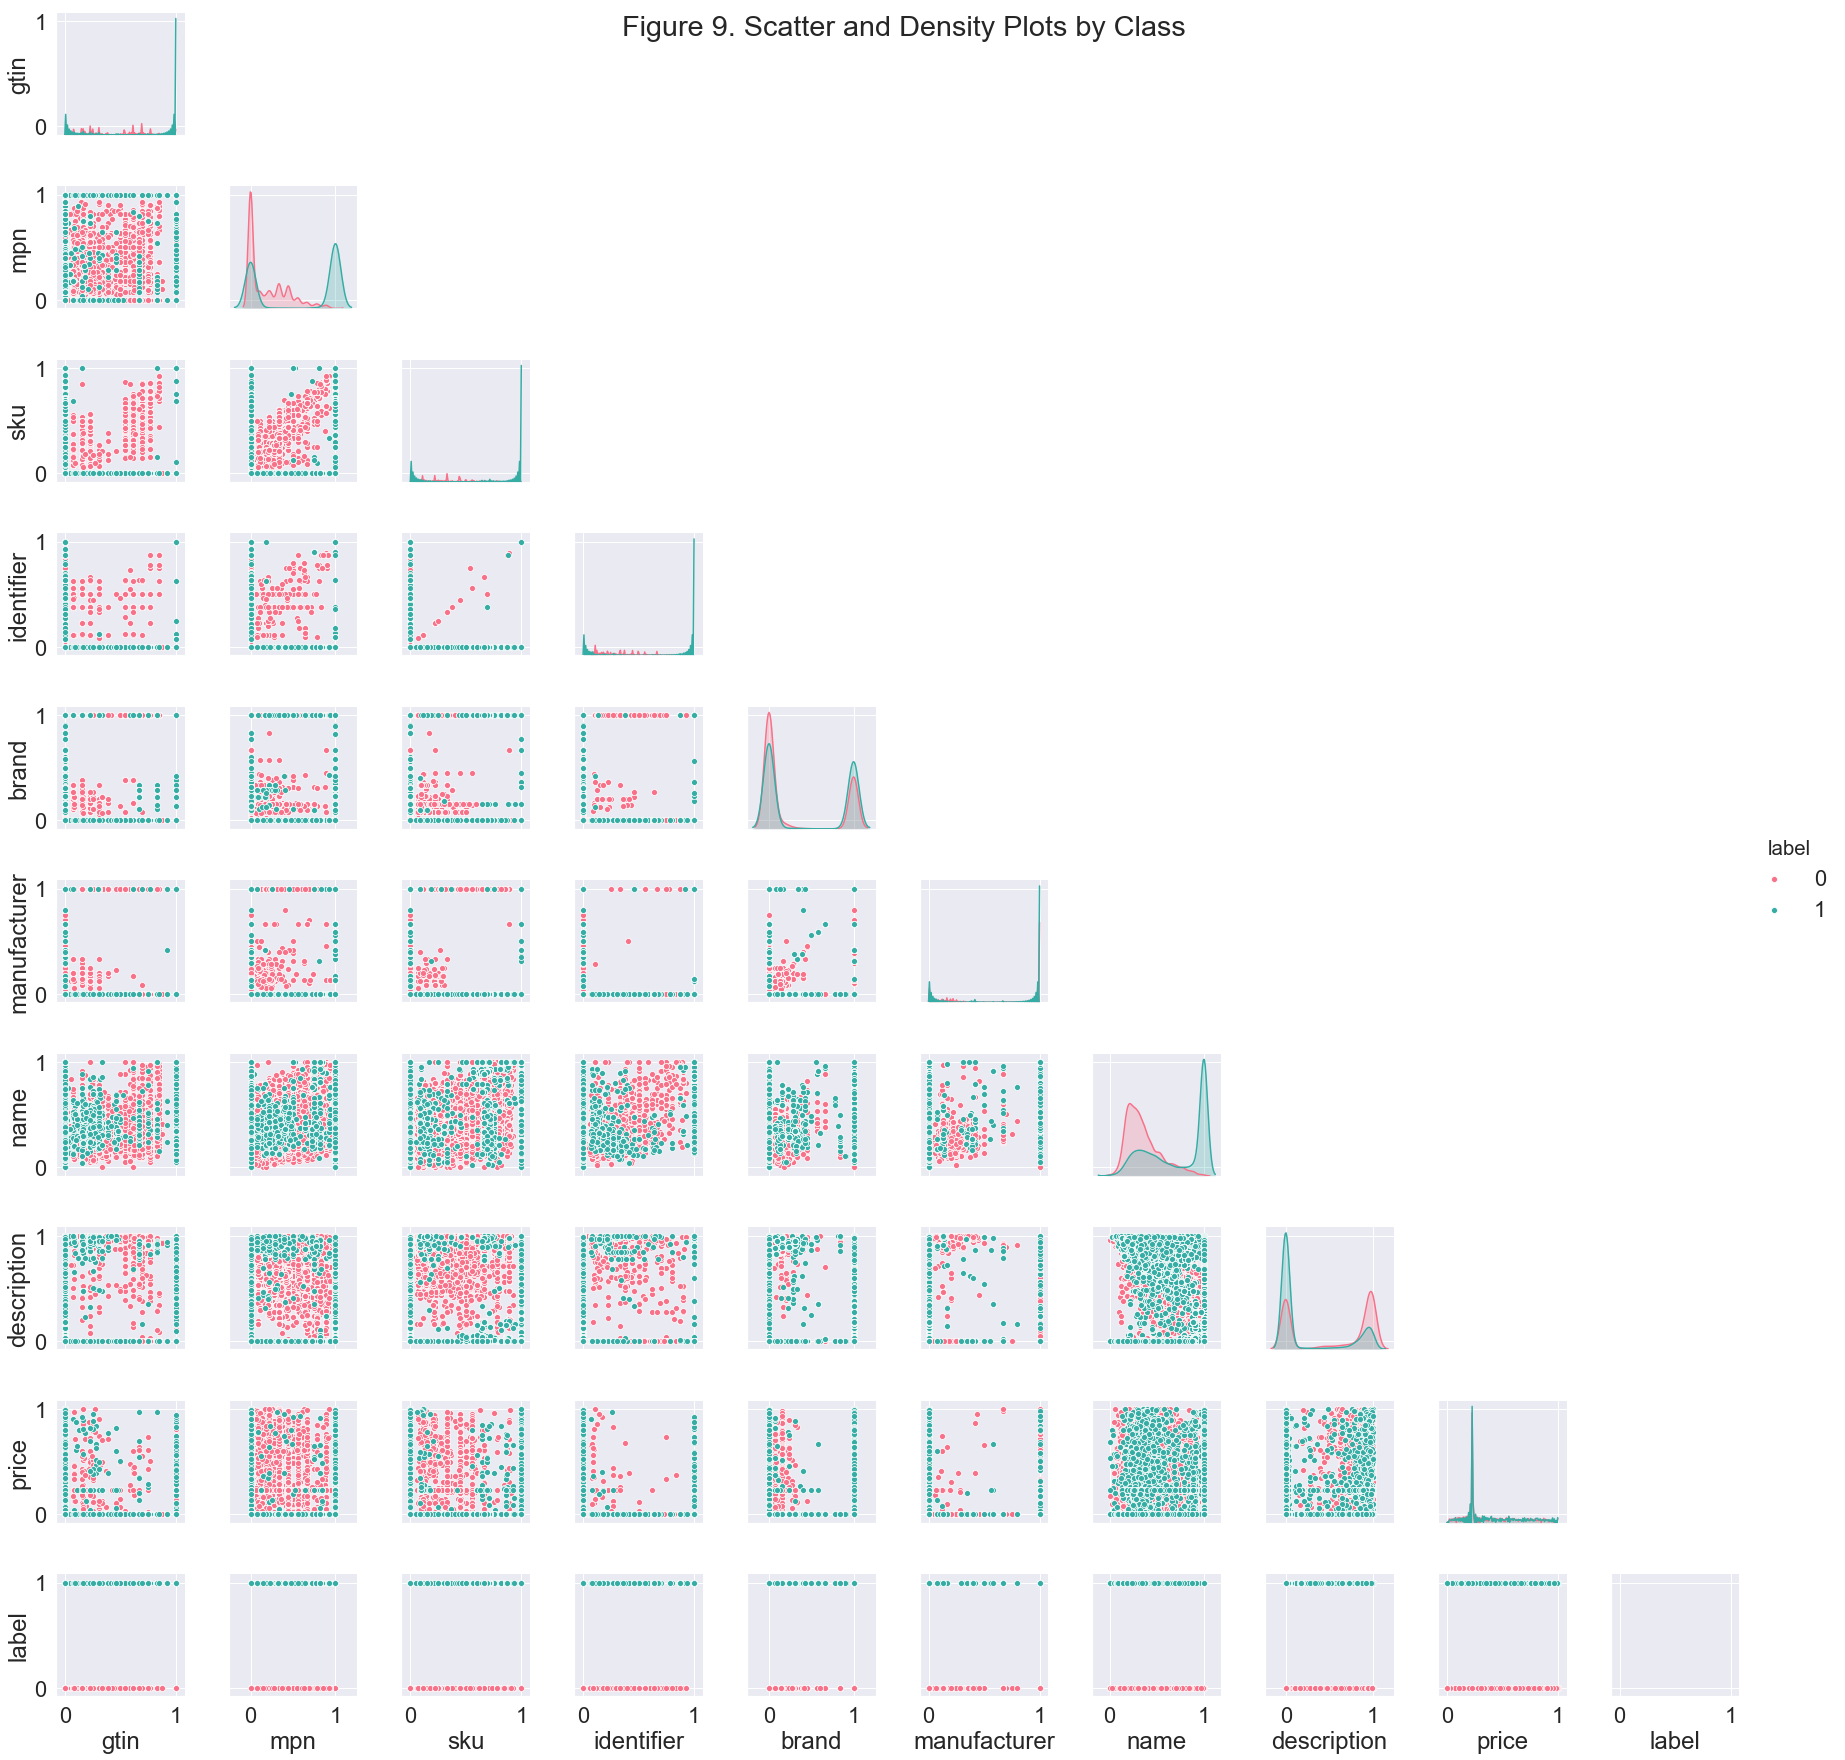

In [54]:
plt.figure(figsize=(12, 12))
sns.set(font_scale=2)

g = sns.pairplot(attribute_comp_features_9_feat_label, hue='label', palette="husl")

g.fig.suptitle("Figure 9. Scatter and Density Plots by Class")
g.map_upper(hide_current_axis)
plt.savefig('fig-09-scatter-density-plots.png', bbox_inches = "tight")

### Correlation Plot

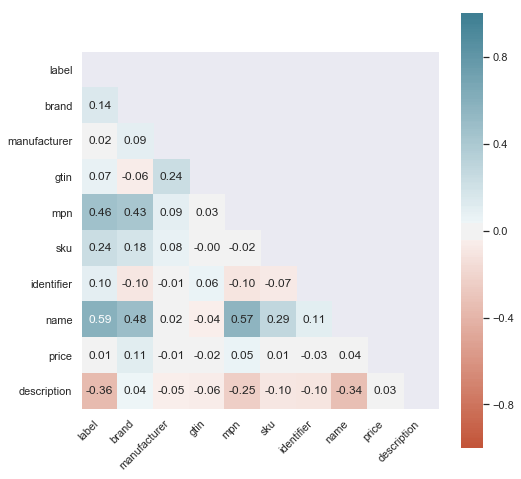

In [50]:
mask = np.zeros_like(feature_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(8, 8))
sns.set(font_scale=1)

ax = sns.heatmap(
    feature_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True, 
    fmt='.2f', 
    mask=mask
)

# ax.set_title('Correlation')
settings =\
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.savefig('fig-09-correlation.png', bbox_inches = "tight")


In [22]:
feature_corr = attribute_comp_features_9.corr()

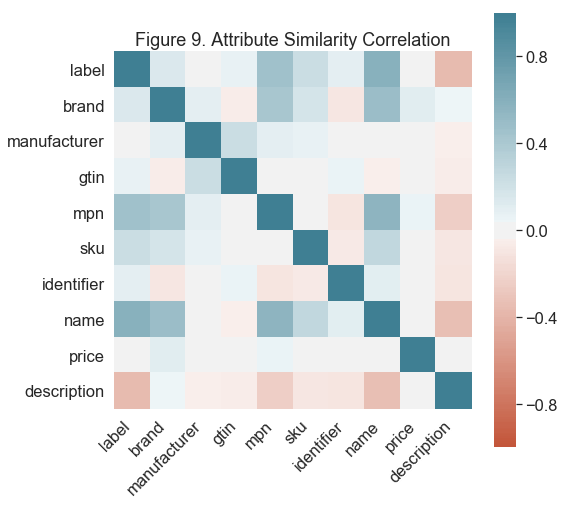

In [23]:
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.5)

ax = sns.heatmap(
    feature_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_title('Figure 9. Attribute Similarity Correlation')

settings =\
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
plt.savefig('fig-09-correlation.png', bbox_inches = "tight")
# source: https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

In [24]:
var_imp = var_imp_coef.Overall.sort_values(ascending=False)
var_coef = var_imp_coef.Coefficient.sort_values(ascending=False)

<Figure size 576x1440 with 0 Axes>

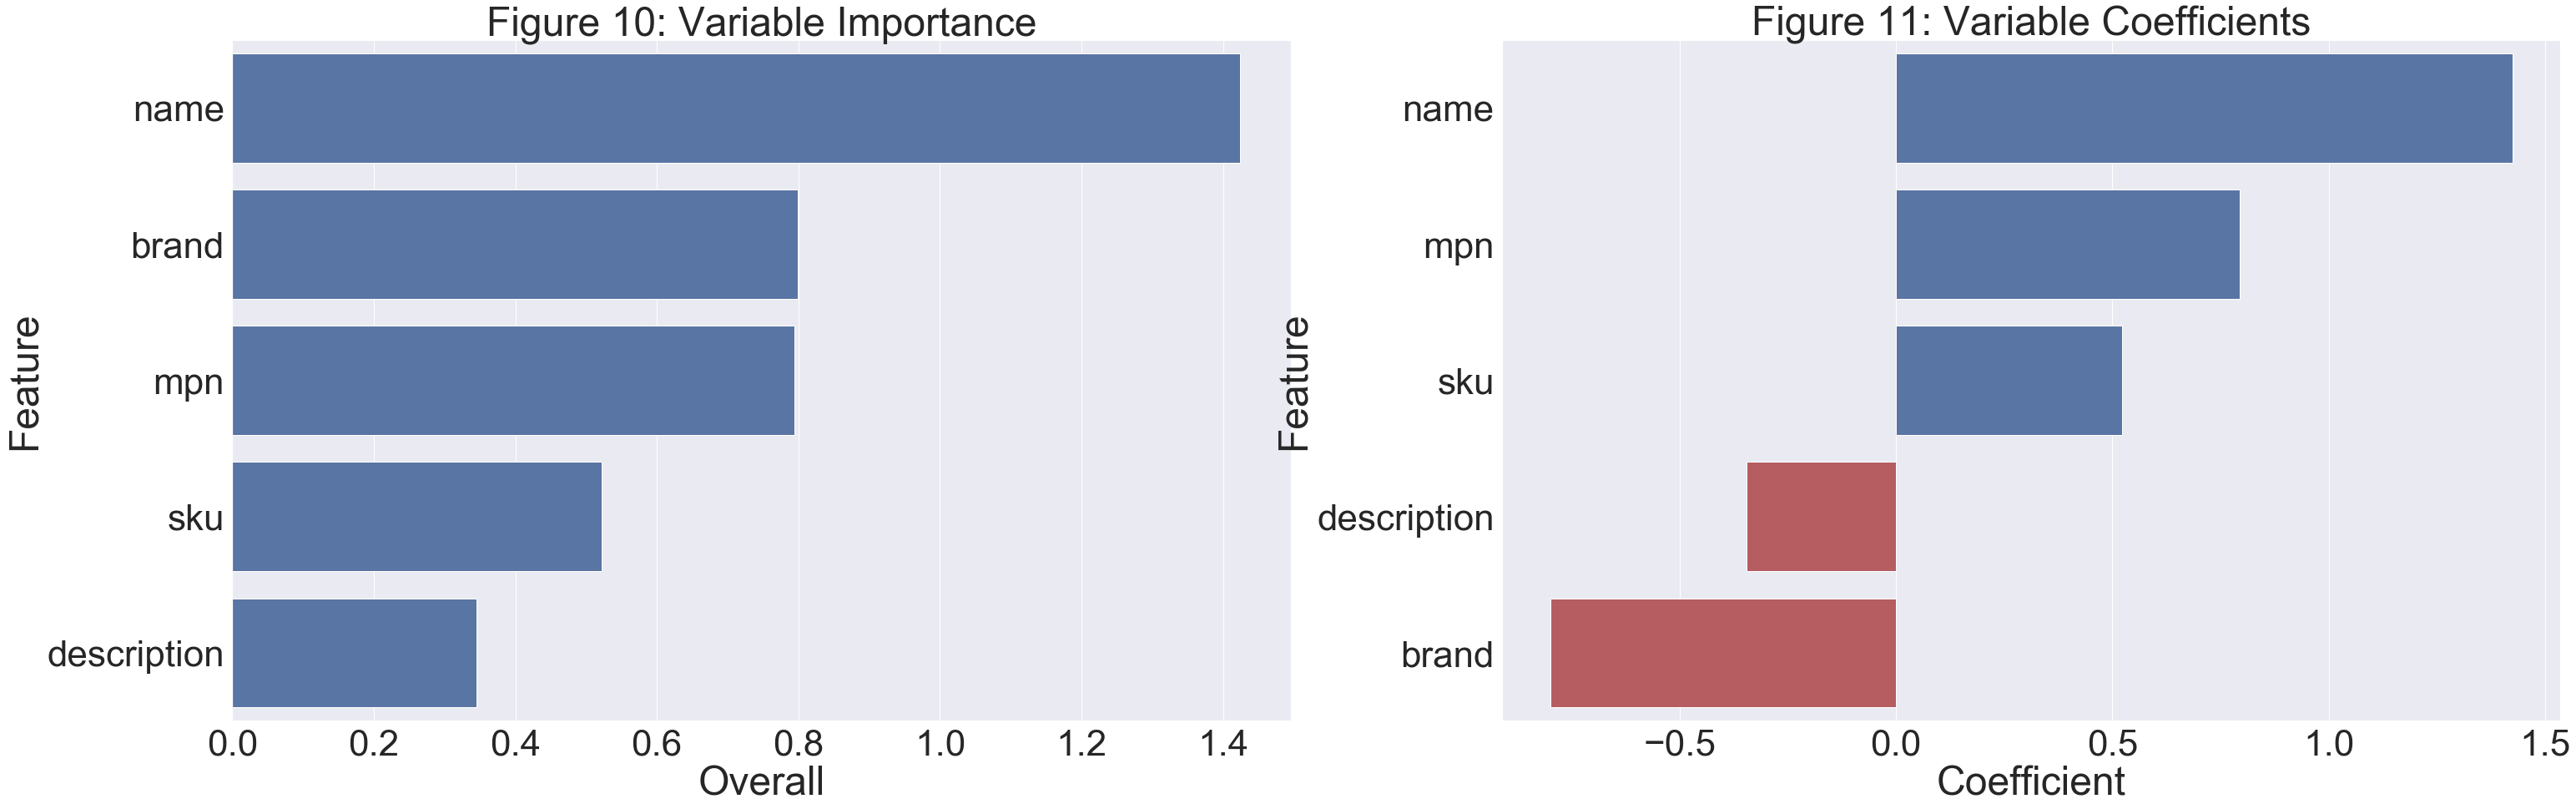

In [25]:
plt.figure(figsize=(8, 20))
sns.set(font_scale=4)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50, 15))
sns.barplot(x=var_imp, 
            y=var_imp.index, 
            color="b", 
            ax=axes[0])\
            .set_title('Figure 10: Variable Importance')

sns.barplot(x=var_coef, 
            y=var_coef.index, 
            palette=var_coef.apply(lambda x: 'b' if x > 0 else 'r'),
            ax=axes[1])\
            .set_title('Figure 11: Variable Coefficients')


plt.savefig('fig-10-11-variable-importance-coefficients.png', bbox_inches = "tight")

### Variable Importance for Best Models

In [26]:
# get variable importance
rf_acf9 = acf9_models[2].best_estimator_ 
input_feature_order = ['brand', 'manufacturer', 'gtin', 'mpn', 'sku', 'identifier', 'name', 'price', 'description']

var_imp_rf = pd.DataFrame({'feature': input_feature_order,
                           'importance': rf_acf9.feature_importances_})\
    .set_index('feature').sort_values('importance', ascending=False)

sgb_acf9 = acf9_models[3].best_estimator_ 
var_imp_sgb = pd.DataFrame({'feature': input_feature_order,
                           'importance': sgb_acf9.feature_importances_})\
    .set_index('feature').sort_values('importance', ascending=False)

os.chdir(ORIGINAL_DIRECTORY)
os.chdir(PLOT_DIRECTORY)

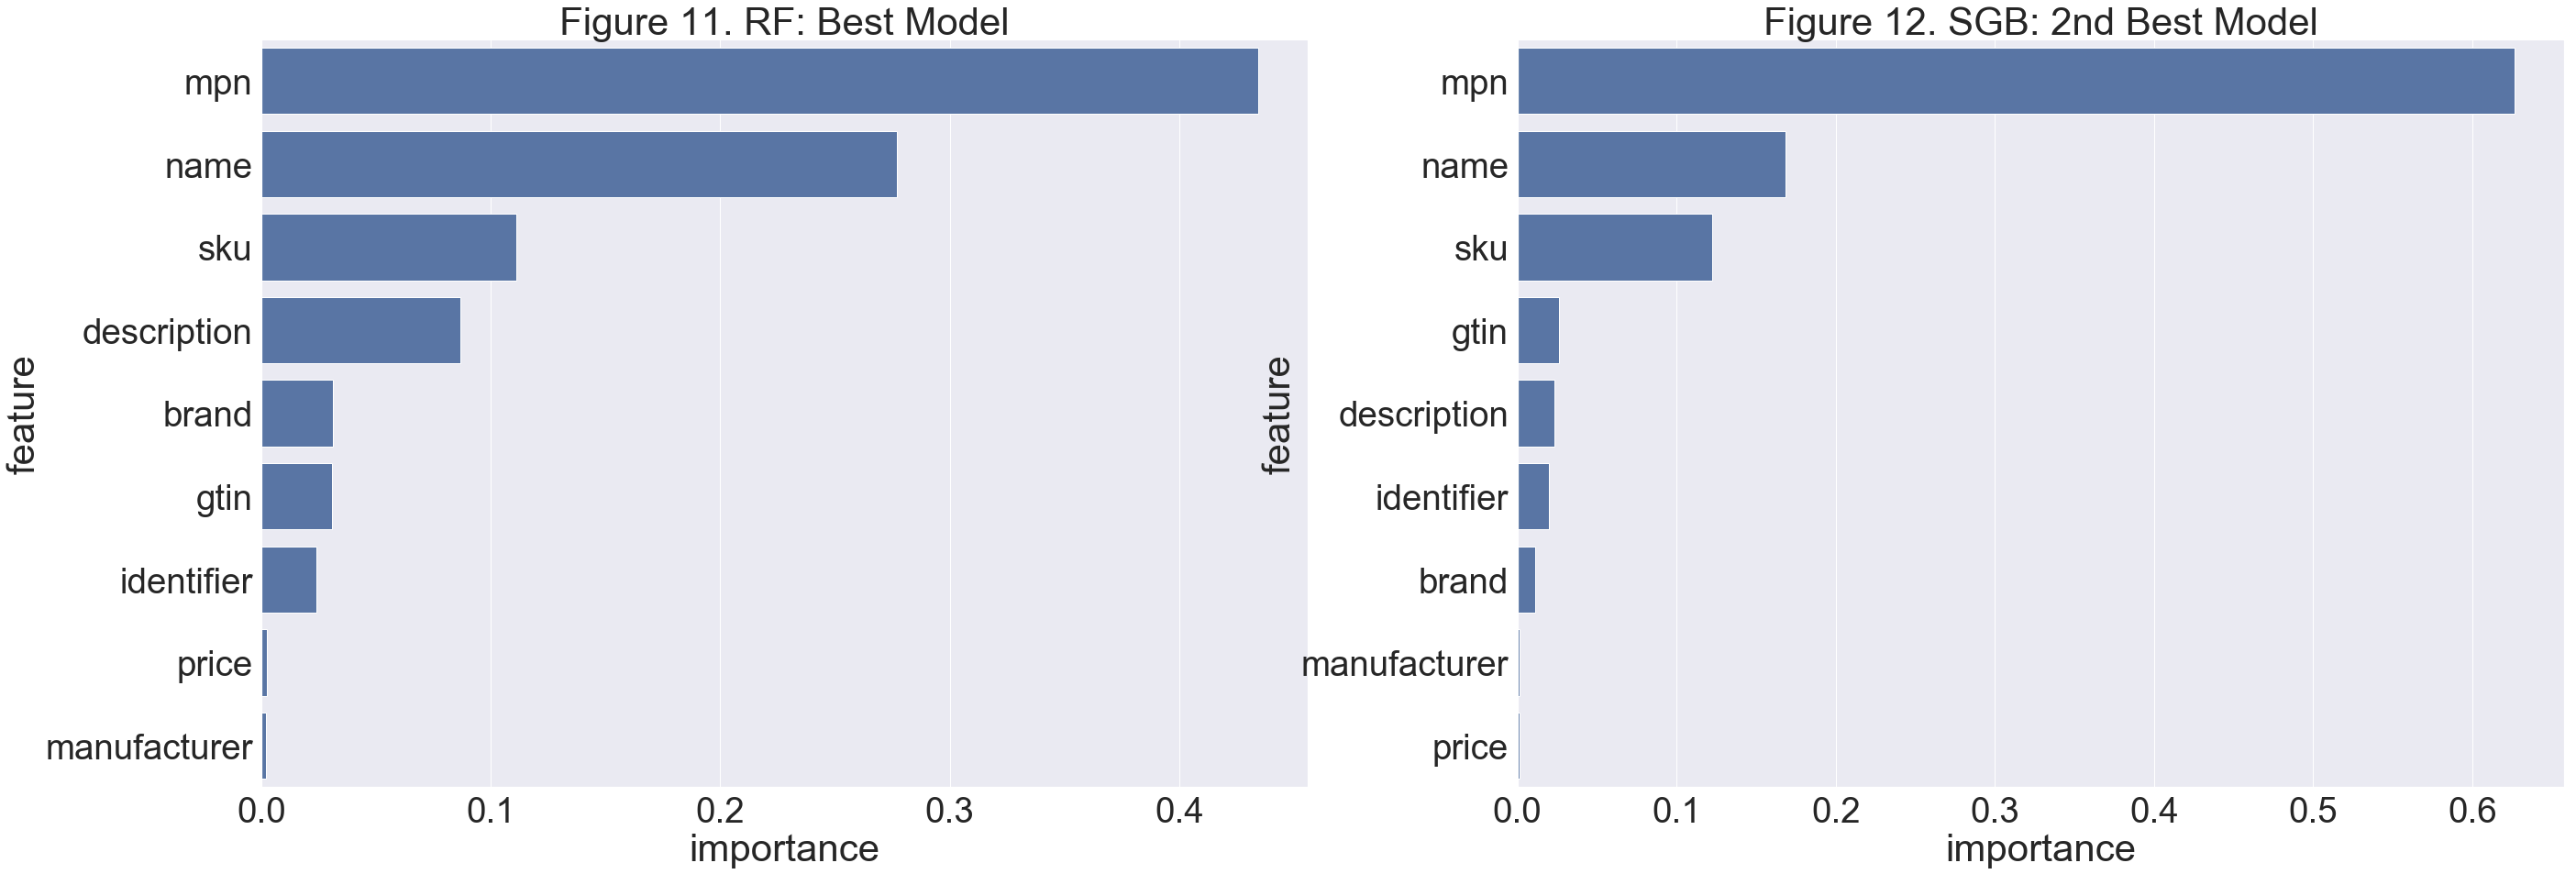

In [27]:
# plot variable importance
sns.set(font_scale=3.5)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45, 15))

sns.barplot(x=var_imp_rf.importance,
           y=var_imp_rf.index,
           color='b',
           ax=axes[0])\
            .set_title('Figure 11. RF: Best Model')

sns.barplot(x=var_imp_sgb.importance,
           y=var_imp_sgb.index,
           color='b',
           ax=axes[1])

t2 = axes[1].set_title('Figure 12. SGB: 2nd Best Model')


plt.savefig('fig-11-12-variable-importance-coefficients.png', bbox_inches = "tight")

### Precision and Recall

In [42]:
# create the curve data
test_labels = attribute_comp_features_9.loc[attribute_comp_features_9.dataset == 'test', 'label']
precision, recall, thresholds = precision_recall_curve(test_labels, acf9_class_proba[:, 1])
thresholds = np.append(thresholds, 1) 

pr_curve_df = pd.DataFrame({'Precision': precision, 
                            'Recall': recall,
                            'Threshold': thresholds})

pr_curve_df['delta'] = np.abs(pr_curve_df.Precision - pr_curve_df.Recall)
pr_curve_df_melted = pd.melt(pr_curve_df.iloc[:, :3], id_vars='Threshold')

<Figure size 7200x2376 with 0 Axes>

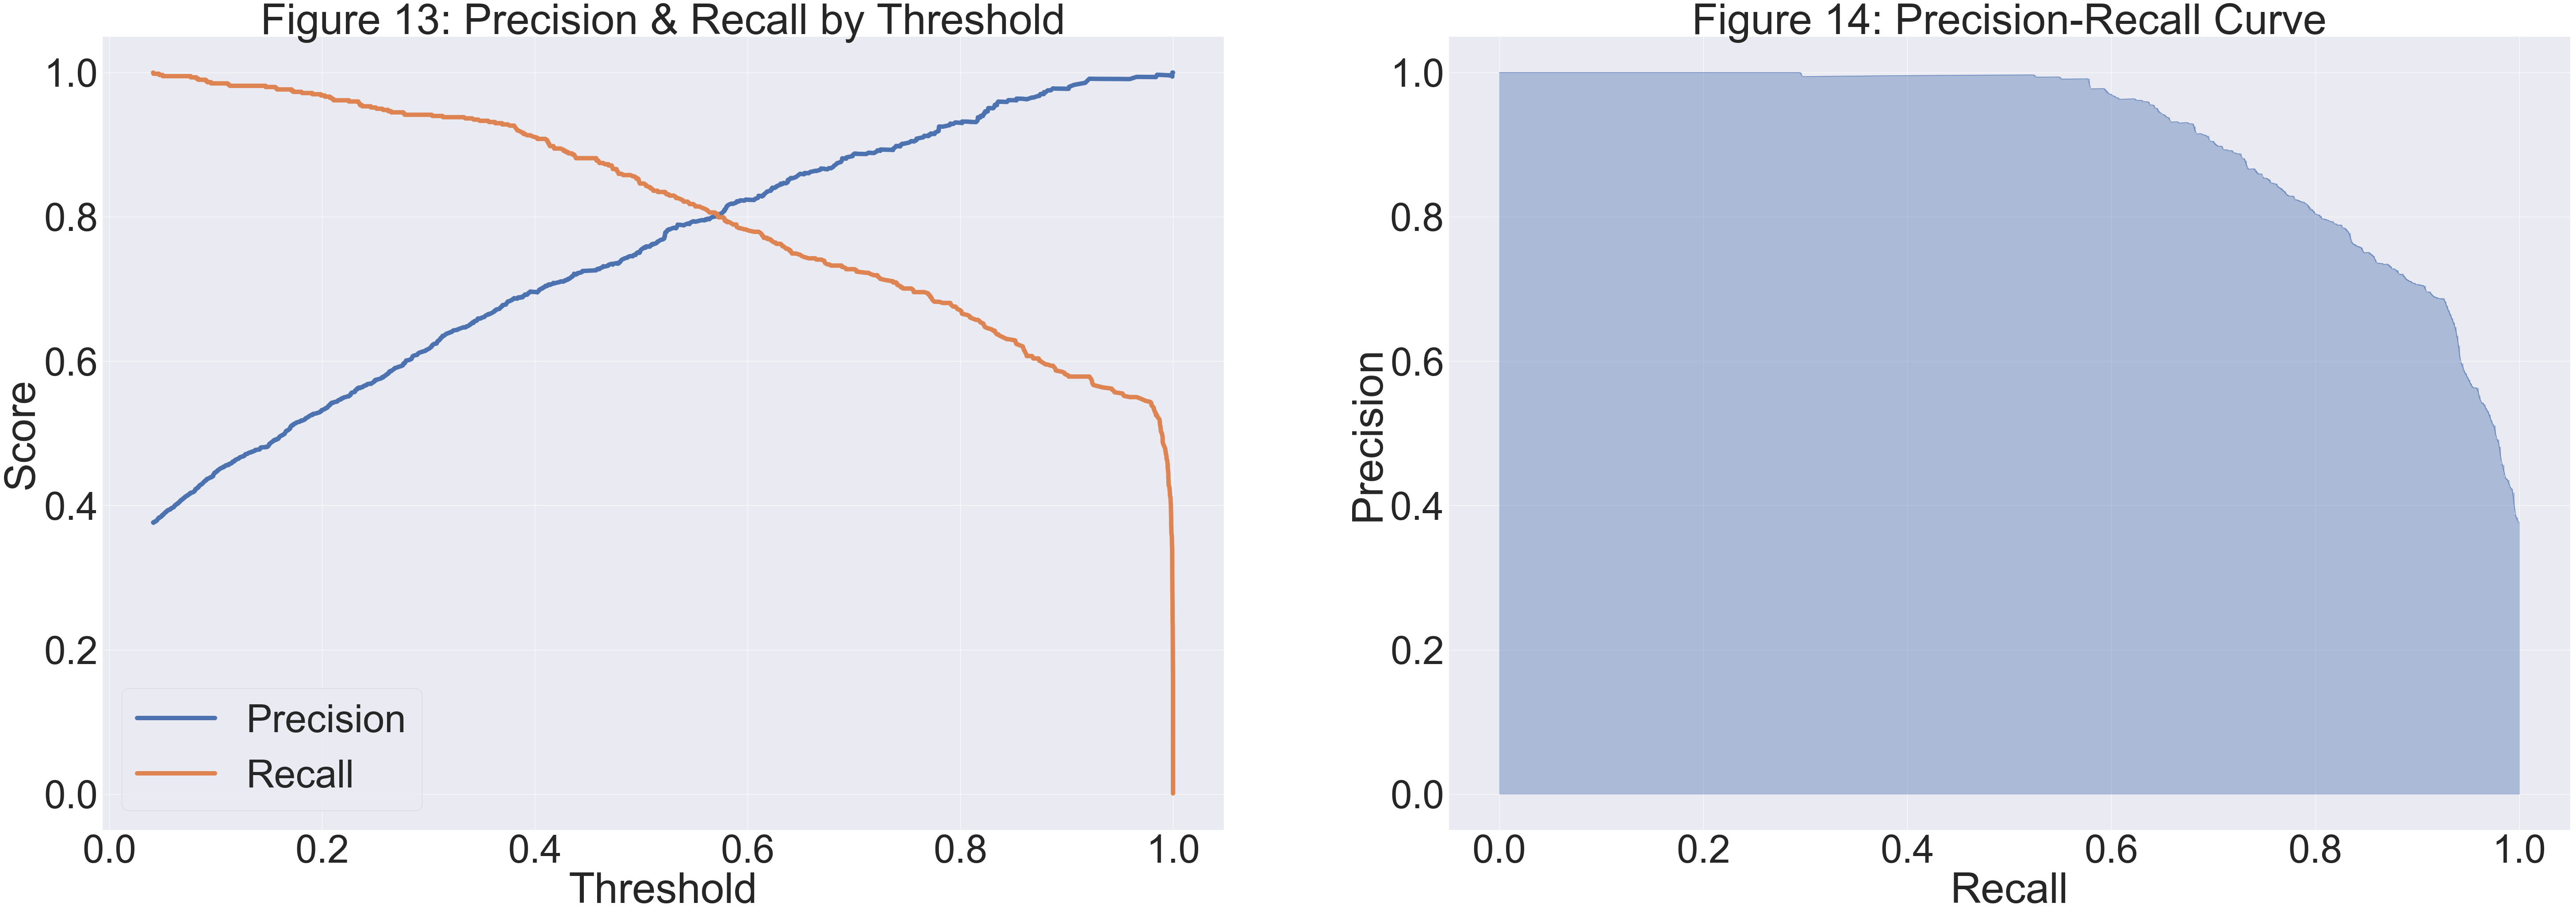

In [29]:
sns.set(font_scale=8)
plt.figure(figsize=(100, 33))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(100, 33))

# plot 1
sns.lineplot(x='Threshold',
            y='value',
            hue='variable',
            data=pr_curve_df_melted,
            ax=axes[0], 
            linewidth=10)\
            .set_title('Figure 13: Precision & Recall by Threshold')


axes[0].legend(('Precision', 'Recall'), frameon=True) 
axes[0].set(ylabel='Score')

# plot 2
sns.lineplot(x='Recall',
             y='Precision',
             data=pr_curve_df, 
             alpha=.7,
             ax=axes[1])\
            .set_title('Figure 14: Precision-Recall Curve')

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

axes[1].fill_between(recall, precision, alpha=0.4, color='b', **step_kwargs)

plt.savefig('fig-13-14-variable-importance-coefficients.png', bbox_inches = "tight")

### Performance by Model

In [30]:
model_avgs_melted = pd.melt(model_avgs, id_vars='Model', var_name='Metric', value_name='Score')

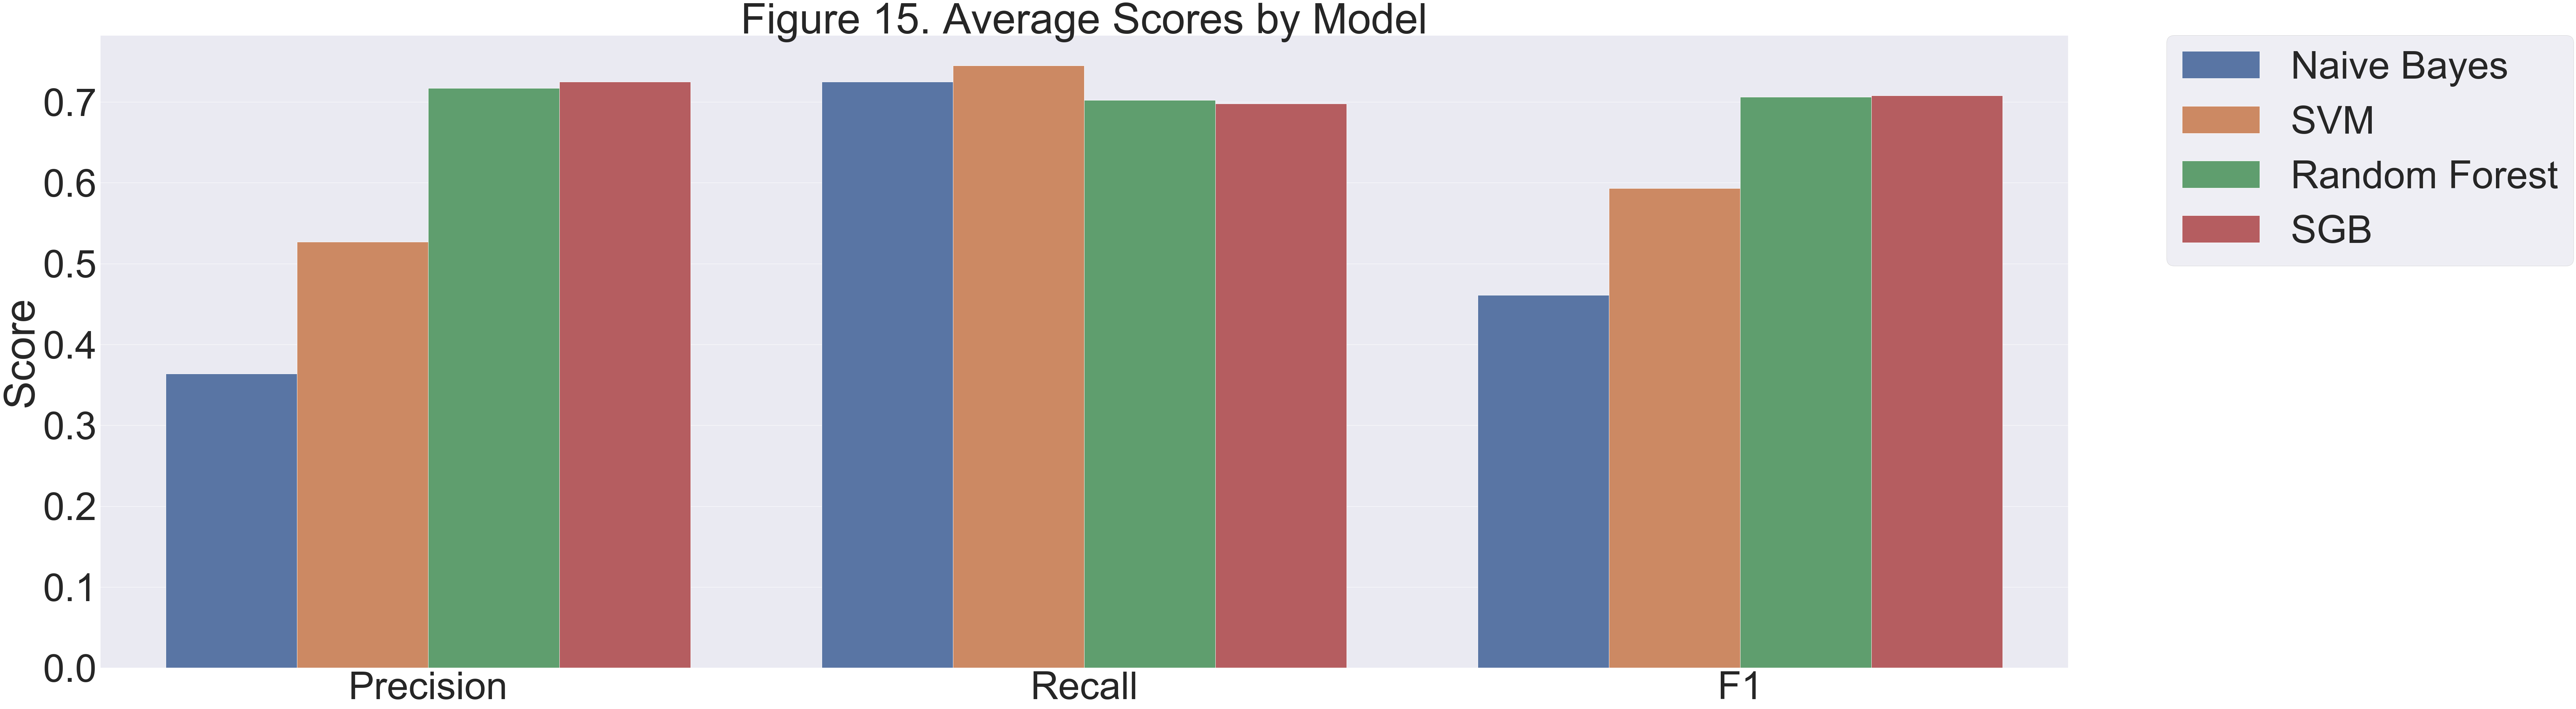

In [37]:
sns.set(font_scale=10)
plt.figure(figsize=(100, 33))

sns.barplot(x='Metric', 
            y='Score',
            hue='Model', 
            data=model_avgs_melted).set_title('Figure 15. Average Scores by Model')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

b = plt.xlabel('')

plt.savefig('fig-15-model-performance.png', bbox_inches = "tight")

### Performance by Feature Set

In [46]:
feature_avgs_melted = pd.melt(feature_avgs, id_vars='Feature Set', var_name='Metric', value_name='Score')


'D:\\Documents\\Large-Scale Product Matching\\attribute_comparison_features-9'

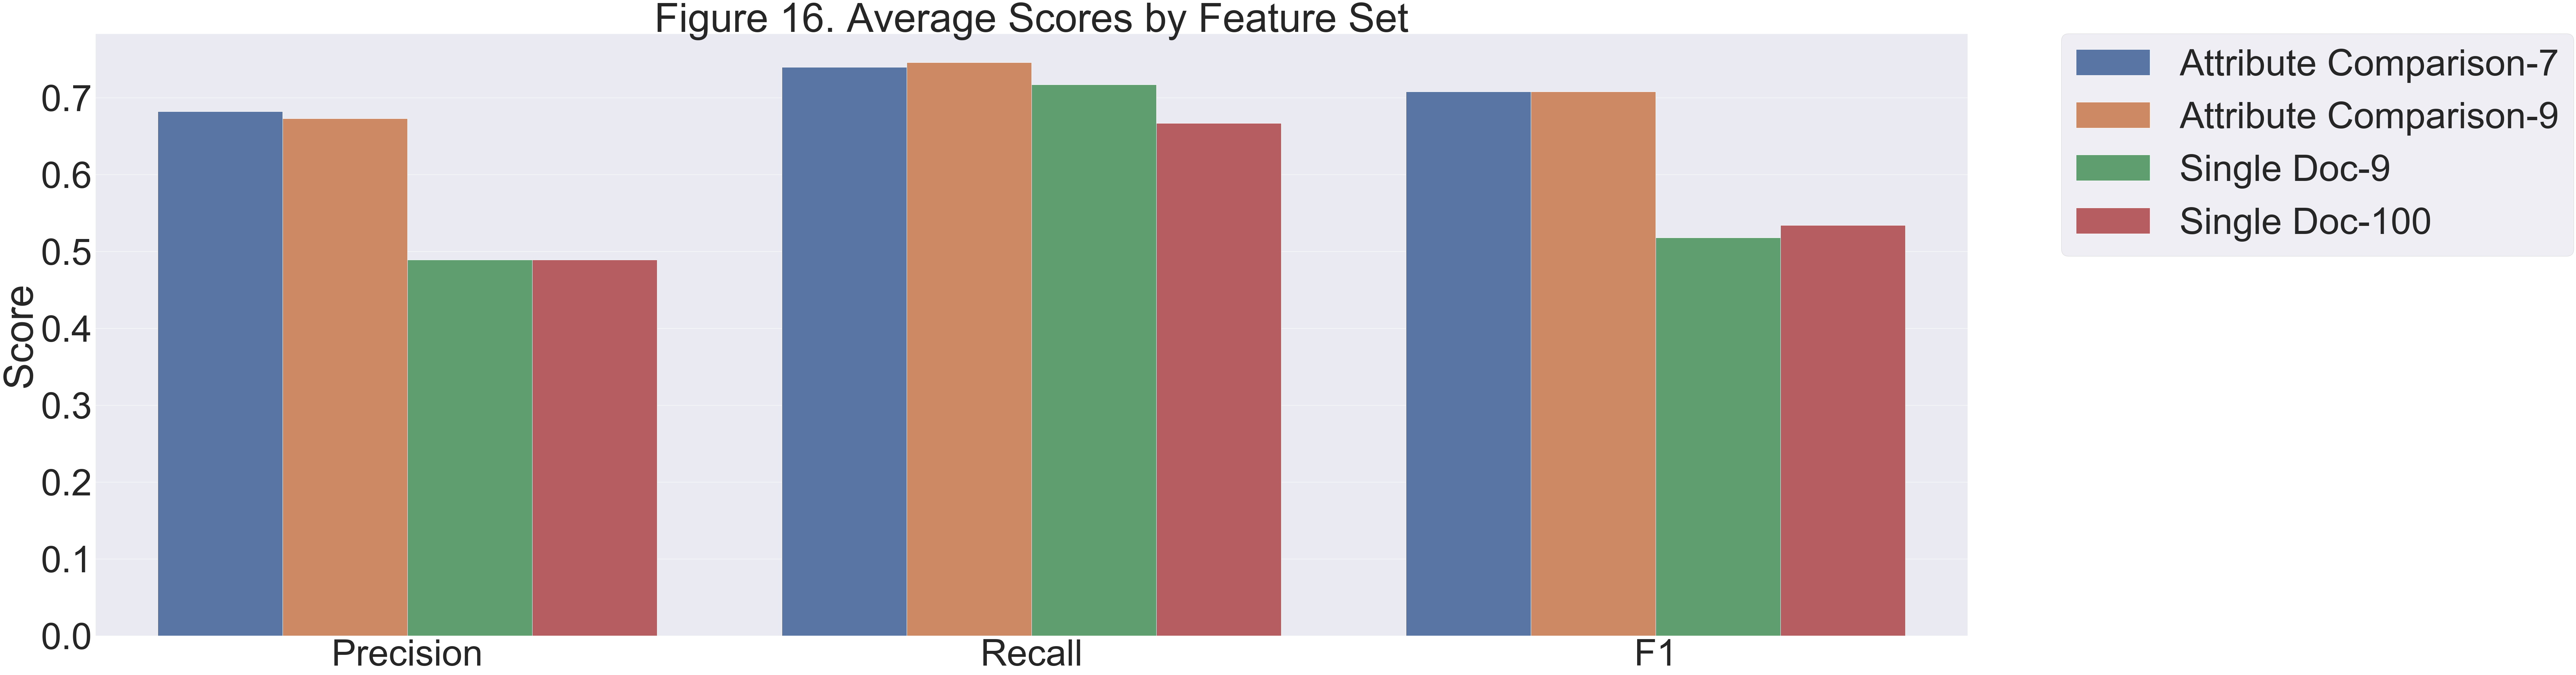

In [48]:
sns.set(font_scale=10)
plt.figure(figsize=(100, 33))

sns.barplot(x='Metric', 
            y='Score',
            hue='Feature Set', 
            data=feature_avgs_melted).set_title('Figure 16. Average Scores by Feature Set')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
b = plt.xlabel('')

plt.savefig('fig-16-feature-performance.png', bbox_inches = "tight")

In [44]:
test_categories = attribute_comp_features_9.loc[attribute_comp_features_9.dataset == 'test', 'file_category']
test_labels


array([1, 1, 1, ..., 0, 0, 0], dtype=uint8)